In [1]:
from enum import Enum
# 用 Enum 來表示 Activation Function，只能二擇一
class ActivationFunction(Enum):
    SIGMOID = 'sigmoid'
    RELU = 'relu'

# Step 0: 設定參數
可以在這裡設定一些 const 的參數值

In [2]:
TEST_SPLIT = 0.2 # 分割測試集的比例
RANDOM_SEED = 42 # 亂數種子

INPUT_SIZE = 8           # 特徵數量 (固定為 8)
HIDDEN_SIZE = 16         # 隱藏層大小 (可調整，例如 8, 16, 32)
OUTPUT_SIZE = 1          # 輸出層大小 (固定為 1，二元分類)
HIDDEN_ACTIVATION = ActivationFunction.RELU # 隱藏層激活函數 (relu 或 sigmoid)
EPOCHS = 1500            # 訓練輪數 (可調整，例如 1000, 2000)
LEARNING_RATE = 0.01     # 學習率 (可調整，例如 0.1, 0.01, 0.001)
VERBOSE_STEP = 100       # 每隔多少輪印出一次損失

# Step 1: Data Processing

## 1.1 取得資料

In [3]:
import kagglehub

d:\Repos\nchu-ai-introduction\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
path = kagglehub.dataset_download("uciml/pima-indians-diabetes-database")
path

'C:\\Users\\User\\.cache\\kagglehub\\datasets\\uciml\\pima-indians-diabetes-database\\versions\\1'

In [5]:
import pandas as pd
df = pd.read_csv(path + "/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## 1.2 處理缺失值

In [7]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

從 `df.describe()` 結果可以看到沒有 null 值  
接著處理缺失值直接被填為 0 的情況

各個 Feature 如下：
- Pregnacies 懷孕次數：可能為 0
- Glucose：血糖：不可能為 0
- BloodPressure 血壓：不可能為 0
- SkinThickness 皮膚厚度：不可能為 0
- Insulin 胰島素濃度：極罕見情況下才會為 0
- BMI：不可能為 0
- DiabetesPedigreeFunction 糖尿病家族函數：在 df.describe() 可以看到沒有 0
- Age 年齡：這個資料集中最少為 21 歲，df.describe() 中可看到最小是 21 沒有問題

In [8]:
# 該處理 0 值的欄位：
cols_to_impute = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in cols_to_impute:
    # 計算非零值的中位數
    median_val = df[df[col] != 0][col].median()
    # 將 0 替換為中位數
    df[col] = df[col].replace(0, median_val)

In [9]:
df.describe() # 看一下處理完的資料

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,29.108073,140.671875,32.455208,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096642,8.791221,86.383060,6.875177,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## 1.3 分離 feature 與 outcome

In [10]:
import numpy as np

In [11]:
x = df.drop('Outcome', axis=1).values
y = np.array(df['Outcome'].values).reshape(-1, 1) # 確保 y 是 (n_samples, 1) 的形狀

In [12]:
x

array([[  6.   , 148.   ,  72.   , ...,  33.6  ,   0.627,  50.   ],
       [  1.   ,  85.   ,  66.   , ...,  26.6  ,   0.351,  31.   ],
       [  8.   , 183.   ,  64.   , ...,  23.3  ,   0.672,  32.   ],
       ...,
       [  5.   , 121.   ,  72.   , ...,  26.2  ,   0.245,  30.   ],
       [  1.   , 126.   ,  60.   , ...,  30.1  ,   0.349,  47.   ],
       [  1.   ,  93.   ,  70.   , ...,  30.4  ,   0.315,  23.   ]],
      shape=(768, 8))

In [13]:
y[:5]

array([[1],
       [0],
       [1],
       [0],
       [1]])

In [14]:
print(x.shape)
print(y.shape)

(768, 8)
(768, 1)


可以看到 X 跟 y 可以一一對應，正確

## 1.4 打亂資料並分割

In [15]:
np.random.seed(RANDOM_SEED)
indices = np.arange(x.shape[0]) # 產生一個索引列表
np.random.shuffle(indices) # 打亂索引列表
x = x[indices] # 使用打亂後的索引來排 X
y = y[indices] # 使用打亂後的索引來排 y

In [16]:
# 分割資料為訓練集和測試集
split_idx = int(x.shape[0] * (1 - TEST_SPLIT))
X_train, X_test = x[:split_idx], x[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

在分割完資料集以後我們需要把資料進行 Normalize  
- 值得注意的是這裡我只使用**訓練集**來計算 min, max，再一起應用到訓練集及測試集
- 這樣可以避免資料探勘的常見錯誤：拿未來的資料（測試集的資料我們訓練時不應該知道）來做訓練

In [17]:
# 標準化 (Min-Max Scaling 到 0-1 的範圍)
# 注意：只在訓練集上計算 min 和 max，然後應用到訓練集和測試集
min_vals = X_train.min(axis=0)
max_vals = X_train.max(axis=0)

# 防止除以零
range_vals = max_vals - min_vals
range_vals[range_vals == 0] = 1 # 如果某特徵所有值都相同時，避免除以零

X_train = (X_train - min_vals) / range_vals
X_test = (X_test - min_vals) / range_vals # 使用訓練集的 min/max 標準化測試集

In [18]:
print("資料載入與預處理完成。")
print(f"訓練集大小: {X_train.shape[0]} 樣本")
print(f"測試集大小: {X_test.shape[0]} 樣本")
print(f"特徵數量: {X_train.shape[1]}")

資料載入與預處理完成。
訓練集大小: 614 樣本
測試集大小: 154 樣本
特徵數量: 8


# Step 2 + 3: Build Neural Network & Training Loop
這一步我們創建一個 SimpleANN，並且把 Training 實作在 Class 裡

## 2.1 Activation Function

In [19]:
def sigmoid(x):
    """Sigmoid activation function"""
    # 防止 overflow
    x = np.clip(x, -500, 500)
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    """Sigmoid activation function 的 derivative"""
    s = sigmoid(x)
    return s * (1 - s)

def relu(x):
    """ReLU activation function"""
    return np.maximum(0, x)

def relu_derivative(x):
    """ReLU activation function 的 derivative"""
    return np.where(x > 0, 1, 0)

## 2.2 Loss Function

In [20]:
def square_error_loss(y_true, y_pred):
    """平方誤差損失函數"""
    return 0.5 * np.mean((y_pred - y_true)**2)

def square_error_loss_derivative(y_true, y_pred):
    """平方誤差損失函數的導數"""
    return y_pred - y_true

## 2.3 實作 SimpleANN Class

In [21]:
import time

In [22]:
class SimpleANN:
    """
    一個簡單的 NumPy 實現的 ANN。
    """

    def __init__(
        self,
        input_size,
        hidden_size,
        output_size,
        hidden_activation: ActivationFunction = ActivationFunction.RELU,
        seed=42,
    ):
        """
        初始化神經網路。

        Args:
            input_size (int): 輸入層神經元數量 (特徵數)。
            hidden_size (int): 隱藏層神經元數量。
            output_size (int): 輸出層神經元數量 (通常為 1 用於二元分類)。
            hidden_activation (str): 隱藏層激活函數 (relu 或 sigmoid)，是 Enum。
            seed (int): 權重初始化的隨機種子。
        """

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.seed = seed
        np.random.seed(self.seed)

        # 權重初始化 (Xavier/Glorot initialization 變體)
        # 這有助於防止梯度消失或爆炸
        limit_w1 = np.sqrt(6.0 / (input_size + hidden_size))
        self.W1 = np.random.uniform(-limit_w1, limit_w1, (self.input_size, self.hidden_size))
        self.b1 = np.zeros((1, self.hidden_size))  # 初始化 bias 為 0

        limit_w2 = np.sqrt(6.0 / (hidden_size + output_size))
        self.W2 = np.random.uniform(-limit_w2, limit_w2, (self.hidden_size, self.output_size))
        self.b2 = np.zeros((1, self.output_size))  # 初始化 bias 為 0

        # 選擇隱藏層 Activation Function
        if hidden_activation == ActivationFunction.RELU:
            self.hidden_activation = relu
            self.hidden_activation_derivative = relu_derivative
        elif hidden_activation == ActivationFunction.SIGMOID:
            self.hidden_activation = sigmoid
            self.hidden_activation_derivative = sigmoid_derivative
        else:
            raise ValueError("隱藏層激活函數必須是 ActivationFunction.RELU " + "或 ActivationFunction.SIGMOID")

        # 輸出層固定使用 Sigmoid
        self.output_activation = sigmoid
        self.output_activation_derivative = sigmoid_derivative

        print("神經網路初始化完成:")
        print(f"  - 輸入層大小: {input_size}")
        print(f"  - 隱藏層大小: {hidden_size}")
        print(f"  - 輸出層大小: {output_size}")
        print(f"  - 隱藏層激活函數: {hidden_activation}")
        print("  - 輸出層激活函數: sigmoid")

    def forward(self, X):  # noqa: N803
        """
        執行前向傳播。

        Args:
            X (np.ndarray): 輸入資料，形狀為 (n_samples, input_size)。

        Returns:
            tuple: (hidden_layer_output, final_output)
                    包含隱藏層和輸出層的輸出。
        """
        # 輸入層到隱藏層
        self.z1 = X @ self.W1 + self.b1
        self.a1 = self.hidden_activation(self.z1)

        # 隱藏層到輸出層
        self.z2 = self.a1 @ self.W2 + self.b2
        self.a2 = self.output_activation(self.z2)  # 最終輸出

        return self.a1, self.a2

    def backward(self, X, y_true, y_pred):  # noqa: N803
        """
        執行反向傳播並計算梯度。

        Args:
            X (np.ndarray): 單個輸入樣本，形狀為 (1, input_size)。
            y_true (np.ndarray): 單個真實標籤，形狀為 (1, output_size)。
            y_pred (np.ndarray): 單個預測輸出，形狀為 (1, output_size)。

        Returns:
            tuple: (dW1, db1, dW2, db2)
                    權重和偏置的梯度。
        """
        # 計算輸出層的誤差和梯度
        # 損失函數對輸出層激活值的導數 * 輸出層激活函數對其輸入的導數
        delta_output = square_error_loss_derivative(y_true, y_pred) * self.output_activation_derivative(self.z2)
        # (1, output_size)

        # 計算隱藏層的誤差和梯度
        # 輸出層誤差 @ W2 的轉置 * 隱藏層激活函數對其輸入的導數
        delta_hidden = (delta_output @ self.W2.T) * self.hidden_activation_derivative(self.z1)
        # (1, hidden_size)

        # 計算權重和偏置的梯度
        # 梯度 = 上一層的激活值轉置 @ 當前層的誤差
        dW2 = self.a1.T @ delta_output  # noqa: N806
        # (hidden_size, 1) @ (1, output_size) -> (hidden_size, output_size)
        db2 = np.sum(delta_output, axis=0, keepdims=True)  # (1, output_size)

        dW1 = X.T @ delta_hidden  # (input_size, 1) @ (1, hidden_size) -> (input_size, hidden_size)  # noqa: N806
        db1 = np.sum(delta_hidden, axis=0, keepdims=True)  # (1, hidden_size)

        return dW1, db1, dW2, db2

    def update_weights(self, dW1, db1, dW2, db2, learning_rate):  # noqa: N803
        """
        使用 SGD 更新 weight 和 bias。

        Args:
            dW1, db1, dW2, db2: 梯度。
            learning_rate (float): 學習率。
        """
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2

    def train(self, X_train, y_train, epochs, learning_rate, verbose=100):  # noqa: N803
        """
        訓練神經網路。

        Args:
            X_train (np.ndarray): 訓練特徵。
            y_train (np.ndarray): 訓練標籤。
            epochs (int): 訓練的輪數。
            learning_rate (float): 學習率。
            verbose (int): 每隔多少輪印出一次損失。

        Returns:
            list: 每輪的平均損失列表。
        """
        start_time = time.time()
        losses = []
        n_samples = X_train.shape[0]

        print("\n開始訓練...")
        print(f"  - Epochs: {epochs}")
        print(f"  - Learning Rate: {learning_rate}")
        print(f"  - 訓練樣本數: {n_samples}")

        for epoch in range(epochs):
            epoch_loss = 0
            # --- SGD: 遍歷每個樣本 ---
            for i in range(n_samples):
                # 獲取單個樣本，並確保其形狀正確 (1, n_features)
                x_sample = X_train[i : i + 1, :]
                y_sample = y_train[i : i + 1, :]

                # 1. 前向傳播
                _, y_pred = self.forward(x_sample)

                # 2. 計算損失 (僅用於記錄，梯度計算在 backward 中)
                loss = square_error_loss(y_sample, y_pred)
                epoch_loss += loss

                # 3. 反向傳播
                dW1, db1, dW2, db2 = self.backward(x_sample, y_sample, y_pred)  # noqa: N806

                # 4. 更新權重 (SGD)
                self.update_weights(dW1, db1, dW2, db2, learning_rate)
            # --- SGD 結束 ---

            # 計算並記錄該 epoch 的平均損失
            average_epoch_loss = epoch_loss / n_samples
            losses.append(average_epoch_loss)

            # print 進度
            if (epoch + 1) % verbose == 0 or epoch == 0:
                print(f"Epoch {epoch + 1}/{epochs}, 平均損失: {average_epoch_loss:.6f}")

        end_time = time.time()
        print(f"訓練完成。總耗時: {end_time - start_time:.2f} 秒")
        return losses

    def predict(self, x):
        """
        使用訓練好的模型進行預測。

        Args:
            x (np.ndarray): 輸入資料。

        Returns:
            np.ndarray: 二元預測結果 (0 或 1)。
        """
        _, final_output = self.forward(x)
        # 將 Sigmoid 輸出轉換為二元預測 (閾值為 0.5)
        predictions = (final_output > 0.5).astype(int)
        return predictions

    def evaluate(self, X_test, y_test):  # noqa: N803
        """
        在測試集上評估模型性能。

        Args:
            X_test (np.ndarray): 測試特徵。
            y_test (np.ndarray): 測試標籤。

        Returns:
            tuple: (accuracy, confusion_matrix)
                準確率和混淆矩陣。
        """
        predictions = self.predict(X_test)
        accuracy = np.mean(predictions == y_test)

        # 計算 confusion matrix
        tp = np.sum((predictions == 1) & (y_test == 1))
        tn = np.sum((predictions == 0) & (y_test == 0))
        fp = np.sum((predictions == 1) & (y_test == 0))
        fn = np.sum((predictions == 0) & (y_test == 1))

        confusion_matrix = np.array([[tn, fp], [fn, tp]])

        print("\n模型評估結果:")
        print(f"  - 測試集準確率: {accuracy:.4f}")
        print(f"  - 混淆矩陣:\n{confusion_matrix}")
        print(f"    - True Negatives (TN): {tn}")
        print(f"    - False Positives (FP): {fp}")
        print(f"    - False Negatives (FN): {fn}")
        print(f"    - True Positives (TP): {tp}")

        return accuracy, confusion_matrix

# Step 3: Evaluation
註：Training 的實作已與 Step 2 一起寫在 Class 中，這邊只進行呼叫訓練的操作

In [23]:
model = SimpleANN(input_size=INPUT_SIZE,
            hidden_size=HIDDEN_SIZE,
            output_size=OUTPUT_SIZE,
            hidden_activation=HIDDEN_ACTIVATION,
            seed=RANDOM_SEED)

神經網路初始化完成:
  - 輸入層大小: 8
  - 隱藏層大小: 16
  - 輸出層大小: 1
  - 隱藏層激活函數: ActivationFunction.RELU
  - 輸出層激活函數: sigmoid


In [24]:
# 訓練模型
losses = model.train(X_train, y_train, epochs=EPOCHS, learning_rate=LEARNING_RATE, verbose=VERBOSE_STEP)


開始訓練...
  - Epochs: 1500
  - Learning Rate: 0.01
  - 訓練樣本數: 614
Epoch 1/1500, 平均損失: 0.120933
Epoch 100/1500, 平均損失: 0.074983
Epoch 200/1500, 平均損失: 0.073965
Epoch 300/1500, 平均損失: 0.072848
Epoch 400/1500, 平均損失: 0.071801
Epoch 500/1500, 平均損失: 0.070995
Epoch 600/1500, 平均損失: 0.070316
Epoch 700/1500, 平均損失: 0.069818
Epoch 800/1500, 平均損失: 0.069477
Epoch 900/1500, 平均損失: 0.069250
Epoch 1000/1500, 平均損失: 0.069071
Epoch 1100/1500, 平均損失: 0.068835
Epoch 1200/1500, 平均損失: 0.068674
Epoch 1300/1500, 平均損失: 0.068566
Epoch 1400/1500, 平均損失: 0.068467
Epoch 1500/1500, 平均損失: 0.068418
訓練完成。總耗時: 55.31 秒


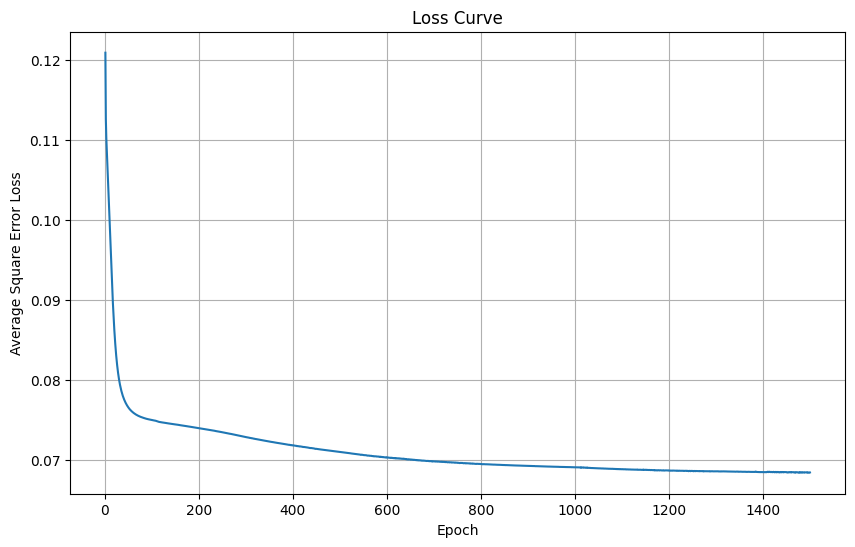

In [25]:
# 繪製 loss vs. epoch
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS + 1), losses)
plt.xlabel("Epoch")
plt.ylabel("Average Square Error Loss")
plt.title("Loss Curve")
plt.grid(True)
plt.show()

# Step 4: Evaluation

In [26]:
accuracy, confusion_mat = model.evaluate(X_test, y_test)


模型評估結果:
  - 測試集準確率: 0.7792
  - 混淆矩陣:
[[83 13]
 [21 37]]
    - True Negatives (TN): 83
    - False Positives (FP): 13
    - False Negatives (FN): 21
    - True Positives (TP): 37


In [28]:
print("最終 Weights:")
print("W1 (Input -> Hidden):\n", model.W1)
print("b1 (Hidden Bias):\n", model.b1)
print("W2 (Hidden -> Output):\n", model.W2)
print("b2 (Output Bias):\n", model.b2)

最終 Weights:
W1 (Input -> Hidden):
 [[-0.25741404  0.60069728  0.21440997 -0.42379298  0.086695   -0.34400548
  -1.74363813  0.17807147  0.09287509  0.59019976 -0.47941551  0.90389712
   0.84638356 -0.28766089 -1.03633838 -0.31627978]
 [-0.19654201 -0.00931814 -0.72662162 -0.8675841   0.12609567 -0.36050614
   0.66263342 -0.39880344 -0.05107465  0.4876268  -0.30032622  0.4195509
   0.45504173 -0.45354959  0.91121065 -0.33806347]
 [-0.77157299  0.46021188  0.22083237  0.81944459 -0.27301264 -0.40232789
   0.01511544  0.14796978 -0.39820967  0.00505847 -0.46561148  0.3161549
  -0.14036066  0.16252228 -0.24637666  0.02033175]
 [-0.42263687 -0.37219503  1.4651971   0.35595754  0.52014502  0.39482735
   0.24193511  0.40418033 -0.41158444  0.23756619 -0.45477271  0.38187806
   0.51132434 -0.22865097  0.31337502 -0.1417006 ]
 [-2.20543495 -0.21231267 -1.04403609  0.13609958 -0.5709749   0.48688694
   0.25049193 -0.23659268 -0.49484632 -0.57550863  0.20685734 -0.78133004
  -0.74563749 -0.425955